# NBA OUTLIER DETECTION USING LOCAL OUTLIER FACTOR METHOD

## 1. Introduction 

In this note book we aim to perform outlier detection on the NBA player data for the years 2000 to 2004. The goal is to find outstanding players and we shall compare the players found to the actual MVPs of those seasons as well as notice the trend in outstanding players over those years.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

## 2. Data Aquisition 

We make use of the data from the basketballreference.com, we only use the player data sets since we are only interested in detecting outstanding players.

In [3]:
player_allstar_df = pd.read_csv('databasebasketball/player_allstar.txt', sep=",")
player_playoffs_career_df = pd.read_csv('databasebasketball/player_playoffs_career.txt', sep=",")
player_playoffs_df = pd.read_csv('databasebasketball/player_playoffs.txt', sep=",")
player_regular_season_career_df = pd.read_csv('databasebasketball/player_regular_season_career.txt', sep=",")
player_regular_season_df = pd.read_csv('databasebasketball/player_regular_season.txt', sep=",")
players_df = pd.read_csv('databasebasketball/players.txt', sep=",")

## 3. Data-Preprocessing

In [7]:
def clean_duplicates(df):
    
    """
    
    This function removes duplicates from the dataframe of interest. Since players are sometimes drafted during 
    a season and we would like to remove the deupliacted information.
    
    
    """
    
    
    
    flagged_duplicates = df.duplicated(subset=['ilkid','year'], keep=False)
    
    to_drop = [] 
    
    for i in range(flagged_duplicates.shape[0]):
        if(flagged_duplicates[i]==True and df.iloc[i]['team'] != "TOT"):
            to_drop.append(i)
    
    for i in range(len(to_drop)):
        df.drop(to_drop[i],inplace=True)
    
    return df

Now we can define our data after we clear out the duplicates from the player_regular_season dataframe. We then visualize the last 10 items in the dataframe

In [5]:
data = clean_duplicates(player_regular_season_df)

In [6]:
data.tail(10)

,ilkid,year,firstname,lastname,team,leag,gp,minutes,pts,oreb,...,stl,blk,turnover,pf,fga,fgm,fta,ftm,tpa,tpm
19102,WILLIFR02,2004,Frank,Williams,CHI,N,9,71,6,2,...,2,3,3.0,9,20,3,0,0,4,0
19103,WILLIJA02,2004,Jason,Williams,MEM,N,71,1952,719,19,...,75,5,130.0,91,644,266,101,80,330,107
19104,WILLIJE01,2004,Jerome,Williams,NYK,N,79,1211,359,115,...,55,10,65.0,155,243,122,172,115,5,0
19105,WILLIKE01,2004,Kevin,Willis,ATL,N,29,344,87,29,...,8,7,15.0,53,90,35,23,17,2,0
19106,WILLIMA01,2004,Maurice,Williams,MIL,N,80,2254,814,50,...,74,11,196.0,221,737,323,160,136,99,32
19107,WILLISC01,2004,Scott,Williams,CLE,N,19,152,33,15,...,4,6,5.0,30,41,12,11,9,1,0
19108,WOODSLO01,2004,Loren,Woods,TOR,N,45,712,176,81,...,8,39,37.0,78,164,71,59,34,1,0
19109,WOODSQY01,2004,Qyntel,Woods,MIA,N,3,40,10,2,...,4,0,2.0,6,12,5,0,0,0,0
19110,WRIGHDO01,2004,Dorell,Wright,MIA,N,3,27,7,0,...,4,0,3.0,2,11,3,1,1,4,0
19111,WRIGHLO02,2004,Lorenzen,Wright,MEM,N,80,2287,771,177,...,58,69,100.0,251,683,320,198,131,3,0


we now need to compute the two values we shall use to perform the outlier detection they are: effciency and the appoximate value. We compute these two values and append them as columns to our dataframe called data.

The efficiency is defined as:

$\mathrm{Efficiency}=\frac{\mathrm{CREDITS}}{\mathrm{GP}}$

where $\mathrm{CREDITS}=\mathrm{PTS+REB+ASTS+STL+BLK-(FGA-FGM)-(FTA-FTM)-TO}$

the approximate value is then computed as:

$\mathrm{Approximate Value}=\frac{\mathrm{CREDITS}^{\frac{3}{4}}}{21}$

In [8]:
data['credits'] = data['pts']+data['reb']+data['asts']+data['stl']+data['blk']-(data['fga']-data['fgm'])-(data['fta']-data['ftm'])-data['turnover']

In [9]:
data['av'] = (data['credits']**(3/4))/21

In [10]:
data['eff'] = data['credits']/data['gp']

We now have the function data_4_year which extracts the subset of data from our dataframe per year. The funtion select_features will get the features to be used for outlier detection from the dataframe and returns it as a numpy array. 

In [11]:
def data_4_year(year):
    data_year = data[data['year']==year]
    data_year.reset_index(inplace=True)
    return data_year

In [12]:
def select_features(data_year):
    X = data_year[['av','eff']].to_numpy()
    X = np.nan_to_num(X)
    return X

## 4. Outlier Detection  

The goal will be to perform outlier detection using local outlier factor for the years 2000 to 2004 

### For the year 2000

We use our functions to get the data and features for the year 2000.

In [17]:
data_for_year = data_4_year(2000)
X = select_features(data_for_year)

Now we use the built in functions from sklearn to perform outlier detection using the lof method. The method also gives a score for how much a point is an outlier.  

In [18]:
clf = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

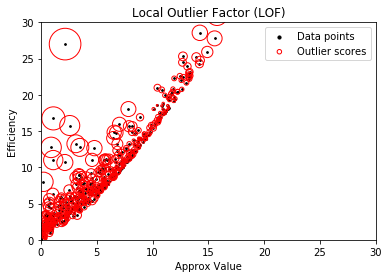

In [24]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',facecolors='none', label='Outlier scores')

plt.axis('tight')
plt.xlim((0, 30))
plt.ylim((0, 30))
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

The above plot shows all of the data for the year 2000 and the circles drawn around each point have a radius which is proportional to the outlier factor which means that circles with larger radii indicate outliers.

Now we define a function that prints the names of the outliers that the lof method predicts for the year 2000. The names are given below.

In [25]:
def print_top_players(X):
    clf = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
    y_pred = clf.fit_predict(X)
    X_scores = clf.negative_outlier_factor_
    
    rank = np.argsort(X_scores)
    for i in range(rank.shape[0]):
        if(X[rank[i]][1]>20 or X[rank[i]][0]>20):
            print(data_for_year.iloc[rank[i]]['firstname'],data_for_year.iloc[rank[i]]['lastname'])

In [26]:
print_top_players(X)

Danny Fortson
Shaquille O'neal
Chris Webber
Kevin Garnett
Tim Duncan
Tracy Mcgrady
Kobe Bryant
Karl Malone
Dirk Nowitzki
Antonio Mcdyess
Vince Carter
Shawn Marion
Marcus Camby
Gary Payton
Steve Francis
Antoine Walker
Shareef Abdur-rahim
Stephon Marbury
Ray Allen
Elton Brand
Jason Kidd
Lamar Odom
Glenn Robinson
Jerry Stackhouse
Paul Pierce
Allen Iverson
Rasheed Wallace
Anthony Mason
Antawn Jamison
Dikembe Mutombo


### For the year 2001

We use our functions to get the data and features for the year 2001. The same process is done as above.

In [43]:
data_for_year = data_4_year(2001)
X = select_features(data_for_year)

In [44]:
clf = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

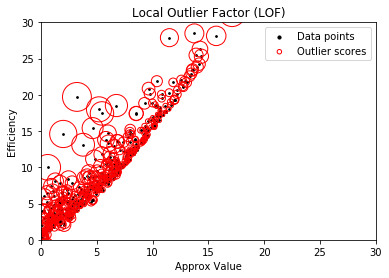

In [45]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',facecolors='none', label='Outlier scores')

plt.axis('tight')
plt.xlim((0, 30))
plt.ylim((0, 30))
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [46]:
print_top_players(X)

Tim Duncan
Kevin Garnett
Shaquille O'neal
Chris Webber
Dirk Nowitzki
Elton Brand
Tracy Mcgrady
Steve Francis
Gary Payton
Paul Pierce
Kobe Bryant
Karl Malone
Vince Carter
Allen Iverson
Andre Miller
Shawn Marion
Ben Wallace
Jason Kidd
Shareef Abdur-rahim
Antoine Walker
Pau Gasol
Jermaine O'neal
Brent Barry
Ray Allen
Sam Cassell
Rasheed Wallace


### For the year 2002

In [48]:
data_for_year = data_4_year(2002)
X = select_features(data_for_year)

In [49]:
clf = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

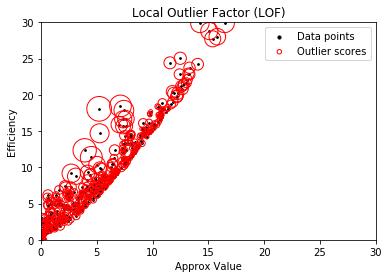

In [50]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',facecolors='none', label='Outlier scores')

plt.axis('tight')
plt.xlim((0, 30))
plt.ylim((0, 30))
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [51]:
print_top_players(X)

Kevin Garnett
Tim Duncan
Shaquille O'Neal
Tracy McGrady
Kobe Bryant
Dirk Nowitzki
Stephon Marbury
Sam Cassell
Ray Allen
Chris Webber
Allen Iverson
Elton Brand
Shawn Marion
Paul Pierce
Gary Payton
Jermaine O'Neal
Jason Kidd
Shareef Abdur-Rahim
Ben Wallace
Steve Francis
Karl Malone
Pau Gasol


### For the year 2003

In [53]:
data_for_year = data_4_year(2003)
X = select_features(data_for_year)

In [54]:
clf = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

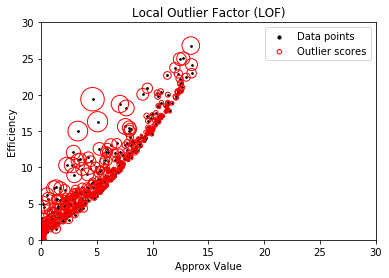

In [55]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',facecolors='none', label='Outlier scores')

plt.axis('tight')
plt.xlim((0, 30))
plt.ylim((0, 30))
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [56]:
print_top_players(X)

Kevin Garnett
Tim Duncan
Elton Brand
Shaquille O'Neal
Dirk Nowitzki
Amare Stoudemire
Tracy McGrady
Ray Allen
Predrag Stojakovic
Brad Miller
Shawn Marion
Kobe Bryant
Carlos Boozer
Andrei Kirilenko
Kenyon Martin
Jermaine O'Neal
Jason Kidd
Zach Randolph
Yao Ming
Stephon Marbury
Paul Pierce
Lamar Odom
Sam Cassell
Erick Dampier


### For the year 2004

In [57]:
data_for_year = data_4_year(2004)
X = select_features(data_for_year)

In [58]:
clf = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

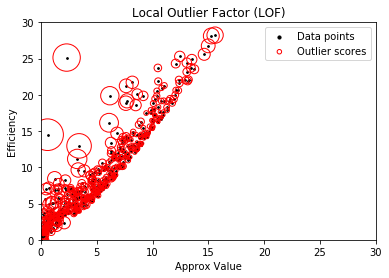

In [59]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',facecolors='none', label='Outlier scores')

plt.axis('tight')
plt.xlim((0, 30))
plt.ylim((0, 30))
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [60]:
print_top_players(X)

Ron Artest
Kevin Garnett
LeBron James
Dirk Nowitzki
Amare Stoudemire
Andrei Kirilenko
Jermaine O'Neal
Shawn Marion
Carlos Boozer
Tim Duncan
Allen Iverson
Shaquille O'Neal
Elton Brand
Tracy McGrady
Kobe Bryant
Dwyane Wade
Stephon Marbury
Brad Miller
Paul Pierce
Vince Carter
Gilbert Arenas
Steve Nash
Larry Hughes
Yao Ming
Steve Francis
Lamar Odom
Chris Webber
Jason Kidd
